In [34]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Linear Regression

In [42]:
class MyLinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        
    def fit(self, X, y):
        n = X.shape[0]
        
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))
        else:
            X_train = X
        
        self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y
        
        return
    
    def predict(self, X):
        
        n = X.shape[0]
        
        if self.fit_intercept:
            X_pred = np.hstack((X, np.ones((n, 1))))
        else:
            X_pred = X
        
        y_pred = X_pred @ self.w
        return y_pred
    
    def get_weights(self):
        return self.w

class Metrics:
    def mae(self, y, y_hat):
        return abs(y - y_hat).mean()
    
    def mse(self, y, y_hat):
        return ((y - y_hat)**2).mean()

In [43]:
object_nums = 50
X = np.linspace(-5, 5, object_nums)

k, m = 8, 12
y = k * X + m + np.random.randn(object_nums) * 5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [139]:
scorer = Metrics()

clf = MyLinearRegression()
clf.fit(X_train[:, np.newaxis], y_train)
y_hat = clf.predict(X_test[:, np.newaxis])

print('w =', clf.get_weights())
print('mse =', scorer.mse(y_hat, y_test))
print('mae =', scorer.mae(y_hat, y_test))

w = [ 7.87154835 12.58910848]
mse = 22.65083866893591
mae = 3.6866257526435318


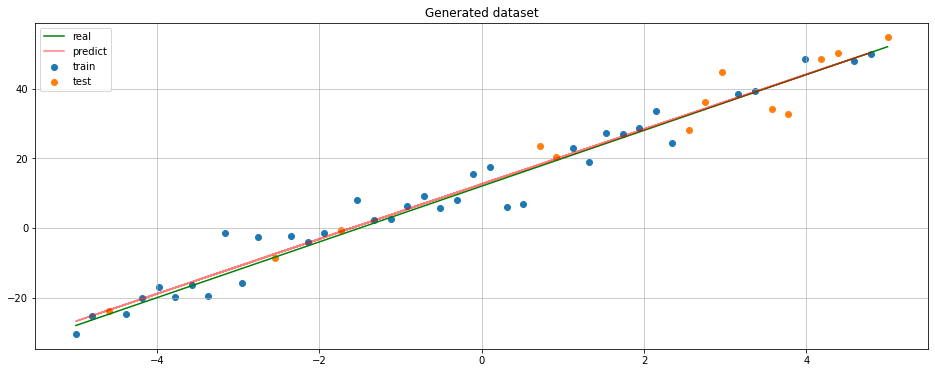

In [45]:
y_pred_train = clf.predict(X_train[:, np.newaxis])

plt.figure(figsize=(16, 6))
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, k * X + m, label='real', c='g')
plt.plot(X_train, y_pred_train, label='predict', c='r', alpha=.5)

plt.title('Generated dataset')
plt.grid(alpha=.8)
plt.legend()
plt.show()

## Градиентный спуск

In [100]:
class MyGradientLinearRegression(MyLinearRegression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        
    def fit(self, X, y, lr=.01, max_iter=100):
        
        if X.ndim == 1:
            n = X.shape[0]
            k = 0
        else:
            n, k = X.shape
        
        if self.w is None:
            self.w = np.random.randn(k + 1 if self.fit_intercept else k)
            
        X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X
        
        self.losses = []
        
        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(mean_squared_error(y_pred, y))
            
            grad = self._calc_gradient(X_train, y, y_pred)
            
            assert grad.shape == self.w.shape, f'gradient shape {grad.shape} is not equal weights shape {self.w.shape}'
            self.w -= lr * grad
            
        return
    
    def _calc_gradient(self, X, y, y_pred):
        grad = 2 * (y_pred - y)[:, np.newaxis] * X
        grad = grad.mean(axis=0)
        return grad
    
    def get_losses(self):
        return self.losses

In [140]:
glr = MyGradientLinearRegression()

glr.fit(X_train[:, np.newaxis], y_train)
y_hat = lrg.predict(X_test[:, np.newaxis])
print('w =', glr.get_weights())
print('mse = ', scorer.mse(y_hat, y_test))
print('mae = ', scorer.mae(y_hat, y_test))

w = [ 7.7092655 10.702963 ]
mse =  22.650838668935958
mae =  3.686625752643552


Text(0.5, 1.0, 'Gradient descent learning')

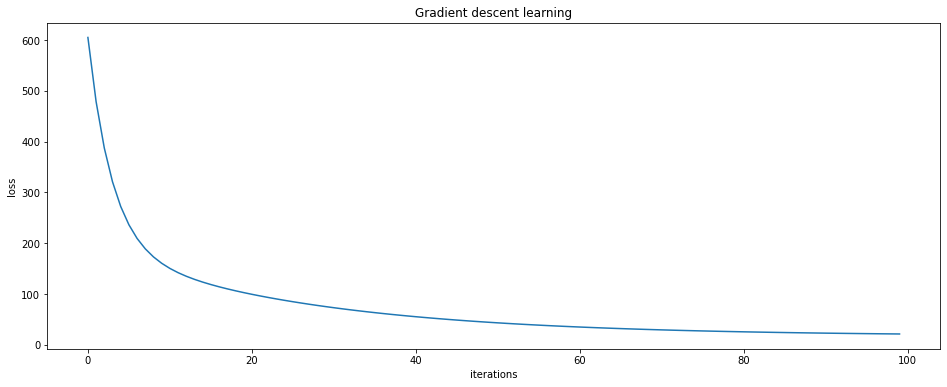

In [127]:
plt.figure(figsize=(16, 6))
plt.plot(glr.get_losses())
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Gradient descent learning')

## SGD

In [128]:
class MySGDLinearRegression(MyGradientLinearRegression):
    def __init__(self, n_sample=10, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        self.n_sample = n_sample
        
    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)
        
        grad = 2 * (y_pred[inds] - y[inds])[:, np.newaxis] * X[inds]
        grad = grad.mean(axis=0)
        
        return grad

In [149]:
sgdlr = MySGDLinearRegression()

sgdlr.fit(X_train[:, np.newaxis], y_train, lr=.01, max_iter=100)
y_hat = sgdlr.predict(X_test[:, np.newaxis])
print(sgdlr.get_weights())
print('mse = ', scorer.mse(y_hat, y_test))
print('mae = ', scorer.mae(y_hat, y_test))

[ 7.62180281 10.36015305]
mse =  31.620838382396048
mae =  4.697738082464163


Text(0.5, 1.0, 'Gradient descent learning')

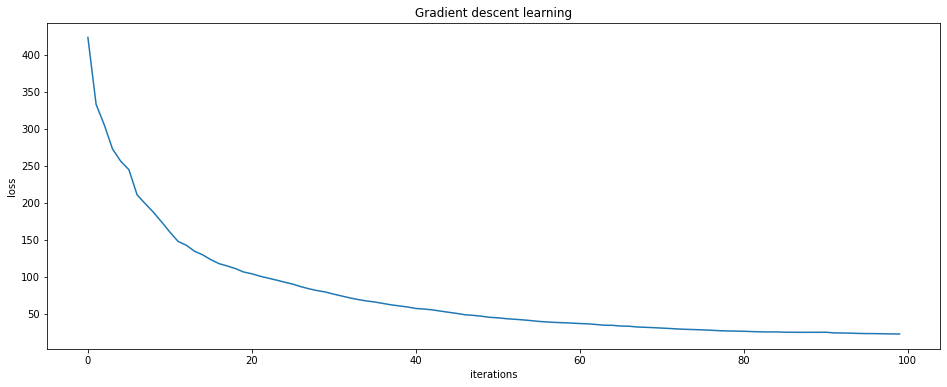

In [150]:
plt.figure(figsize=(16, 6))
plt.plot(sgdlr.get_losses())
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Gradient descent learning')

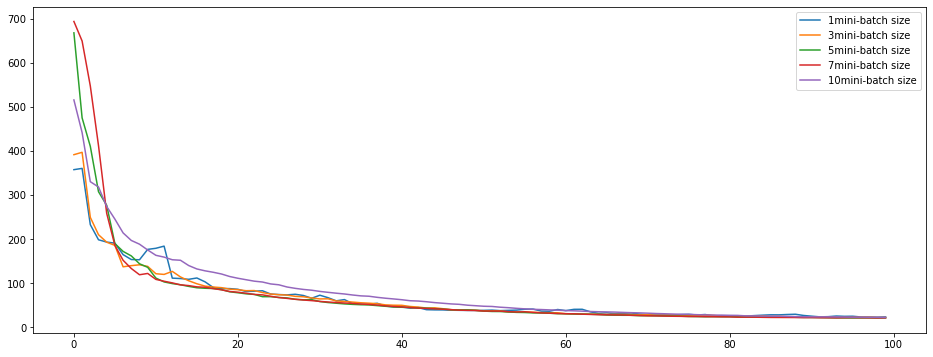

In [167]:
n_samples = [1, 3, 7, 10]
plt.figure(figsize=(16, 6))
for n_sample in [1, 3, 5, 7, 10]:
    sgdlr = MySGDLinearRegression(n_sample=n_sample)
    sgdlr.fit(X_train[:, np.newaxis], y_train)
    l = sgdlr.get_losses()
    plt.plot(l, label=str(n_sample) + 'mini-batch size')
    plt.legend()

## Logistic Regression

In [178]:
def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

class MyLogisticRegression(object):
    def __init__(self):
        self.w = None
        
    def fit(self, X, y, max_iter=100, lr=0.1):
        n, k = X.shape
        
        if self.w is None:
            self.w = np.random.randn(k + 1)
            
        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
        
        self.losses = []
        
        for iter_num in range(max_iter):
            z = sigmoid(logit(X_train, self.w))
            grad = np.dot(X_train.T, (z - y)) / len(y)
            
            self.w -= grad * lr
            
            self.losses.append(self.__loss(y, z))
                
    def predict_proba(self, X):
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))
    
    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold
    
    def get_weights(self):
        return self.w
    
    def __loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

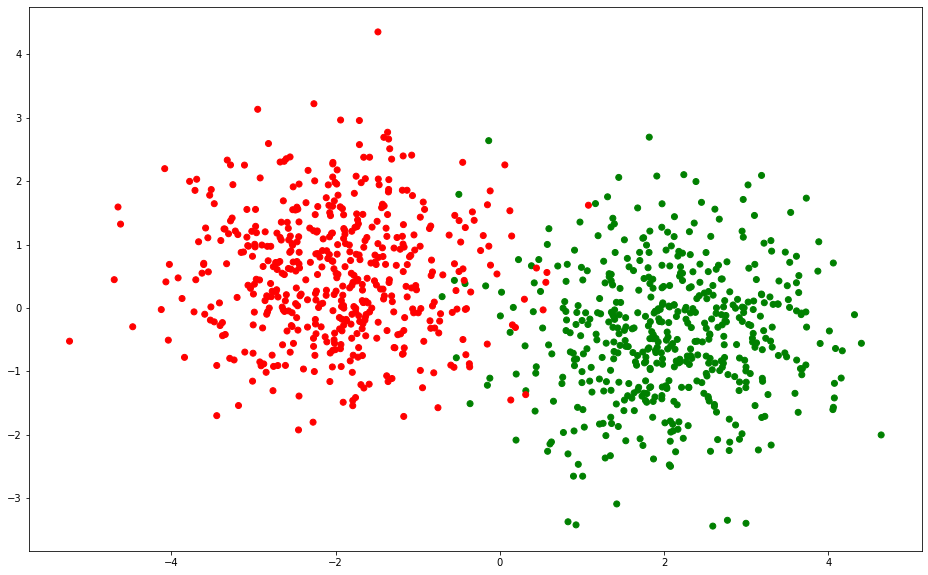

In [184]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2, 0.5], [2, -0.5]], cluster_std=1, random_state=42)
colors = ('red', 'green')
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0, 1]):
    colored_y[y == cl] = str(colors[i])
    
plt.figure(figsize=(16, 10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

In [185]:
clf = MyLogisticRegression()
clf.fit(X, y, max_iter=1000)

w = clf.get_weights()

C:\Users\malt2\AppData\Local\Temp/ipykernel_6504/3438312470.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


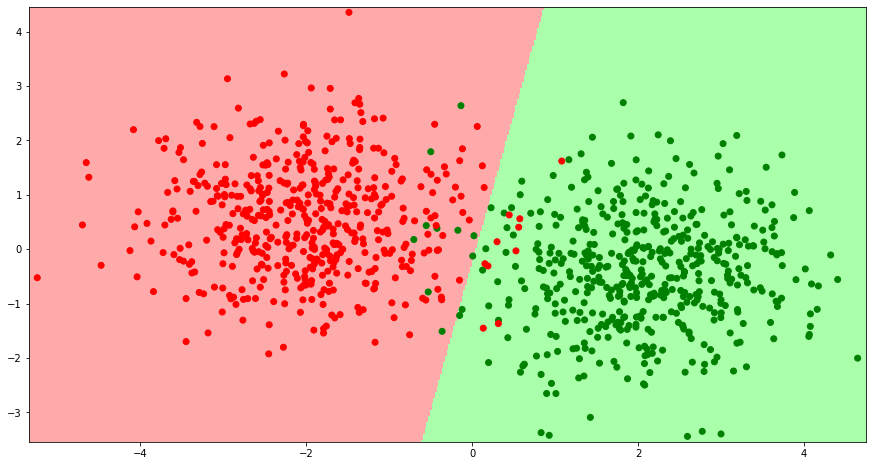

In [187]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.figure(figsize=(15, 8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:, 0]) - eps, np.max(X[:, 0]) + eps, 500),
                    np.linspace(np.min(X[:, 1]) - eps, np.max(X[:, 1]) + eps, 500))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=colored_y)

C:\Users\malt2\AppData\Local\Temp/ipykernel_6504/1557707404.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=plt.get_cmap('viridis'))


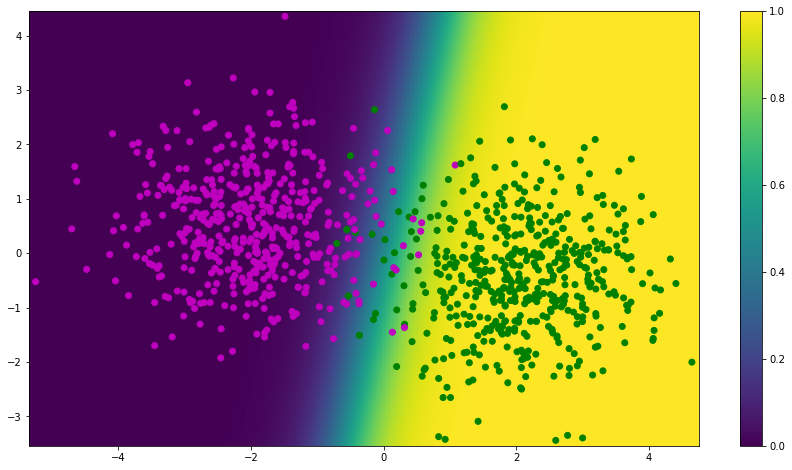

In [212]:
colors = ('magenta', 'green')
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0, 1]):
    colored_y[y == cl] = str(colors[i])
    
plt.figure(figsize=(15, 8))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.get_cmap('viridis'))

plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.colorbar()
plt.show()